# Purpose

Perform Natural Language Processing on the Articles retrieved from the Google search term 'Blockchain'. Analysis includes:

1. Scraping Data from Google 
2. Data Cleaning (Removal of Stop Words, Lemmatisation)
3. Calculating the TF-IDF (Term Frequency - Inverse Document Frequency) and Visualisation using a Word Cloud

## 1. Scrape Google News

[Source]: (<https://serpapi.com/blog/scrape-google-news-with-python/> "Web Scraping Google News with Python")

In [1]:
from newspaper import Article, ArticleException
from parsel import Selector

import itertools, json, re, requests
import pandas as pd


### Initialise Google Parameters

In [2]:
news_results = { "Title":[], "URL":[], "Query": [] }

params = { # your serpapi api key
    "api_key": "1d553d360048563c4f56ef483f4345d7d94b233a88f1301f75fa0e2d226300d6",  
    "engine": "google",         # serpapi parsing engine
    "q": "blockchain",          # search query
    "gl": "us",                 # country from where search comes from
    "tbm": "nws"                # news results
    # other parameters such as language `hl` and number of news results `num`, etc.
}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36"
}


### Make Requests to Google

In [3]:
url = "https://www.google.com/search"


def get_links():

    # get titles / links
    titles = selector.xpath('//div/div[@data-hveid]/a[contains(@href, "https://")]/div/div[last()]/div[contains(@role, "heading")]/text()').getall()
    links = selector.xpath('//div/div[@data-hveid]/a[contains(@href, "https://")]/@href').getall()

    
    # loop titles/links
    for ( title, url )  in zip( titles, links):
        # append
        news_results['Title'].append( title )
        news_results['URL'].append( url )
        news_results['Query'].append( params['q'] )

# loop 10 pages
for i in range(0, 25):


    # request html
    html = requests.get( url , headers=headers, params=params, timeout=30)
    selector = Selector( text=html.text )

    # get data
    get_links()

    url = selector.css('a#pnnext::attr(href)').get()
    url = 'https://www.google.com/' + url



### Store Data

In [4]:
news_results_df = pd.DataFrame.from_dict( news_results )

news_results_df.head()

,Title,URL,Query
0,Takeaways from Davos: Blockchain is changing t...,https://cointelegraph.com/news/takeaways-from-...,blockchain
1,SoftBank joins game-focused blockchain Oasys a...,https://techcrunch.com/2023/02/16/softbank-joi...,blockchain
2,"Avalanche Blockchain Had 1,500% Transactional ...",https://www.coindesk.com/tech/2023/02/14/avala...,blockchain
3,VeChain: Sign in with Google and send transact...,https://www.crypto-news-flash.com/vechain-sign...,blockchain
4,Regulatory Crackdown Feels ‘Like a Crypto Carp...,https://decrypt.co/121399/regulatory-crackdown...,blockchain


In [5]:
news_results_df.shape

(249, 3)

### Inspect Duplicates

In [6]:
# inspect duplicates
news_results_df[ news_results_df.duplicated(keep=False) ].head() 

,Title,URL,Query
1,SoftBank joins game-focused blockchain Oasys a...,https://techcrunch.com/2023/02/16/softbank-joi...,blockchain
5,Cardano Gets 'Valentine' Upgrade: Here’s How i...,https://www.coindesk.com/tech/2023/02/15/carda...,blockchain
18,SoftBank joins game-focused blockchain Oasys a...,https://techcrunch.com/2023/02/16/softbank-joi...,blockchain
27,Wyoming Lawmakers Pass Bill Prohibiting Forced...,https://www.coindesk.com/policy/2023/02/16/wyo...,blockchain
29,Wyoming Lawmakers Pass Bill Prohibiting Forced...,https://www.coindesk.com/policy/2023/02/16/wyo...,blockchain


In [7]:
# remove dupes - they are just sites with differing page ranks
news_results_df = news_results_df.drop_duplicates()

news_results_df.shape


(224, 3)

### Parse URLs as Articles

In [8]:
urls = []
text = []

# loop df urls
for url in news_results_df['URL']:
    
    # initialise article
    article = Article(url)
    
    # download article
    article.download()
    
    # try
    try:
        # parse url content
        article.parse()
        
        # append url/text
        urls.append( url )
        text.append( article.text )
    
    # except
    except ArticleException:
        pass
    
    
    
    

In [9]:
# initialise dictionary
retrieved_articles = { 'url': urls, 'text': text }

# initialise dataframe
retrieved_articles_df = pd.DataFrame( retrieved_articles )

# inspect shape
retrieved_articles_df.shape


(187, 2)

In [10]:
# set colwidth to max
#pd.set_option('display.max_colwidth', None)

retrieved_articles_df

,url,text
0,https://cointelegraph.com/news/takeaways-from-...,The COP has also created tools to prevent clim...
1,https://techcrunch.com/2023/02/16/softbank-joi...,As many observers question what real value blo...
2,https://www.coindesk.com/tech/2023/02/14/avala...,"Notable projects include Core Web, a free, all..."
3,https://www.crypto-news-flash.com/vechain-sign...,VeChain: Sign in with Google and send transact...
4,https://decrypt.co/121399/regulatory-crackdown...,"In a recent interview on CNBC’s Squawk Box, Bl..."
...,...,...
182,https://www.sec.gov/news/press-release/2023-7,FOR IMMEDIATE RELEASE\n\n2023-7\n\nThe Securit...
183,https://www.ft.com/content/6d049669-1fac-40d8-...,What is included in my trial?\n\nDuring your t...
184,https://www.nytimes.com/2022/12/05/business/cr...,When BlockFi’s marketing materials and sales a...
185,https://time.com/6215042/crypto-washington-dc-...,"To the untrained ear, Hester Peirce’s comment ..."


### Tokenise Articles

[Source]: (<https://www.bluetickconsultants.com/summary-extraction-of-an-article-using-experimental-NLP-techniques.html/> "Summary extraction of an article using experimental NLP techniques")

1. Removing unwanted Punctuation for the text
2. Removing URLs from the text
3. Removing hashtags
4. Removing Extra white spaces
5. Removing the own mentions


[Source]: (<https://www.geeksforgeeks.org/removing-stop-words-nltk-python/> "Removing stop words with NLTK in Python")


In [11]:
import nltk 

In [12]:
"""
tokenise article text
"""
def tokenizeArticles( articles ):
    tokenisedArticles = []

    pattern = r'''(?x)                  # flag to allow verbose expressions
        (?:[A-Za-z]\.)+                 # abbreviations, e.g. U.A.E.
        | [A-Za-z]+(?:[-'][A-Za-z]*)?   # words including punctuation
    '''

    tokenizer = nltk.RegexpTokenizer( pattern )

    # iterate articles
    for article in articles:
        
        # if
        if article is not None:
            
            # try 
            try:
                # set to lowercase
                lowerTokenisedArticle = article.lower()
                
                # tokenise
                tokenisedArticles.append( tokenizer.tokenize( lowerTokenisedArticle ) )
                
            # except    
            except TypeError:
                # continue
                continue
        # else
        else:
            # append
            tokenisedArticles.append("")

    return tokenisedArticles

In [13]:
tokenisedArticles = tokenizeArticles( retrieved_articles_df['text'] ) 

retrieved_articles_df['tokens'] = tokenisedArticles

In [14]:
retrieved_articles_df[34:55]

,url,text,tokens
34,https://cointelegraph.com/news/how-to-evaluate...,Fundamental analysis is the process of finding...,"[fundamental, analysis, is, the, process, of, ..."
35,https://www.coindesk.com/markets/2023/02/16/cr...,"Last month, the recently decentralized exchang...","[last, month, the, recently, decentralized, ex..."
36,https://www.coindesk.com/markets/2023/02/16/bi...,Bitcoin Primed to Rally to $56K as Nasdaq Brea...,"[bitcoin, primed, to, rally, to, k, as, nasdaq..."
37,https://www.nature.com/articles/s41598-023-299...,LRC construction\n\nLet the node x with the si...,"[lrc, construction, let, the, node, x, with, t..."
38,https://www.businesswire.com/news/home/2023021...,"SAN FRANCISCO--(BUSINESS WIRE)--CoinTracker, t...","[san, francisco-, business, wire, cointracker,..."
39,https://www.thecoinrepublic.com/2023/02/15/new...,Bets is leading the charge with the launch of ...,"[bets, is, leading, the, charge, with, the, la..."
40,https://www.jdsupra.com/legalnews/crypto-excha...,Key Takeaways\n\nThe U.S. Securities and Excha...,"[key, takeaways, the, u.s., securities, and, e..."
41,https://cryptonews.com/news/bitcoin-margin-fun...,Bitcoin Margin Funding Rate Jumps Amid Latest ...,"[bitcoin, margin, funding, rate, jumps, amid, ..."
42,https://www.bleepingcomputer.com/news/security...,A new malware dubbed 'ProxyShellMiner' exploit...,"[a, new, malware, dubbed, proxyshellminer', ex..."
43,https://fortune.com/crypto/2023/02/16/lido-dec...,It was less than a year ago that the U.S. was ...,"[it, was, less, than, a, year, ago, that, the,..."


### Display Document Stats

In [15]:
from __future__ import division
from itertools import chain
import numpy as np

def stats_print( tokenisedArticles ):
    
    # all words in a list
    words = list( chain.from_iterable( tokenisedArticles ) )

    # vocab 
    vocab = set( words ) 
    
    # lexican diversity
    lexical_diversity = len( vocab )/len( words )

    # print stats for the words and vocabulary
    print( "Vocabulary size: ",                      len( vocab ) )
    print( "Total number of tokens: ",               len( words ) )
    print( "Lexical diversity: ",                    lexical_diversity )
    print( "Total number of articles:",               len( tokenisedArticles ) )
    lens =                                           [ len( article ) for article in tokenisedArticles ]

    # print stats for the document lengths
    print( "Average article length:",               np.mean( lens ) )
    print( "Maximum article length:",               np.max( lens ) )
    print( "Minimum article length:",               np.min( lens ) )
    print( "Standard deviation of article length:", np.std( lens ) )

stats_print(tokenisedArticles)

Vocabulary size:  12078
Total number of tokens:  141559
Lexical diversity:  0.08532131478747378
Total number of articles: 187
Average article length: 757.0
Maximum article length: 3900
Minimum article length: 37
Standard deviation of article length: 666.1125228128716


### Remove Stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.probability import * 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

words     = list( chain.from_iterable( tokenisedArticles ) )
vocab     = set(words)
stopwords = set( stopwords.words('english') )

# remove stopwords
tokenisedArticles = [ [ word for word in article if word not in stopwords ] \
                      for article in tokenisedArticles ]

tokenisedArticles[0:5]

[['cop',
  'also',
  'created',
  'tools',
  'prevent',
  'climate',
  'doomsday',
  'economic',
  'tools',
  'voluntary',
  'compliance',
  'carbon',
  'markets',
  'carbon',
  'credits',
  'green',
  'bonds',
  'green',
  'assets',
  'tied',
  'positive',
  'environmental',
  'impact',
  'play',
  'crucial',
  'role',
  'decarbonization',
  'global',
  'efforts',
  'however',
  'often',
  'inaccessible',
  'small',
  'medium-sized',
  'companies',
  'developing',
  'countries',
  'main',
  'reasons',
  'high',
  'upfront',
  'costs',
  'complex',
  'structuring',
  'processes',
  'line',
  'global',
  'green',
  'standards',
  'positive',
  'negative',
  'impacts',
  'environment',
  'forecasted',
  'described',
  'according',
  'approved',
  'methodologies',
  'information',
  'used',
  'future',
  'monitoring',
  'reporting',
  'verified',
  'assurance',
  'providers',
  'greenwashing',
  'deceptive',
  'eco-claims',
  'may',
  'occur',
  'on-chain',
  'verification',
  'brings',
 

### Lemmatise Words

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tokenisedArticles = [ [ lemmatizer.lemmatize( word ) for word in article ] \
                      for article in tokenisedArticles ]

retrieved_articles_df['cleaned_tokens'] = tokenisedArticles

In [20]:
retrieved_articles_df

,url,text,tokens,cleaned_tokens
0,https://cointelegraph.com/news/takeaways-from-...,The COP has also created tools to prevent clim...,"[the, cop, has, also, created, tools, to, prev...","[cop, also, created, tool, prevent, climate, d..."
1,https://techcrunch.com/2023/02/16/softbank-joi...,As many observers question what real value blo...,"[as, many, observers, question, what, real, va...","[many, observer, question, real, value, blockc..."
2,https://www.coindesk.com/tech/2023/02/14/avala...,"Notable projects include Core Web, a free, all...","[notable, projects, include, core, web, a, fre...","[notable, project, include, core, web, free, a..."
3,https://www.crypto-news-flash.com/vechain-sign...,VeChain: Sign in with Google and send transact...,"[vechain, sign, in, with, google, and, send, t...","[vechain, sign, google, send, transaction, wit..."
4,https://decrypt.co/121399/regulatory-crackdown...,"In a recent interview on CNBC’s Squawk Box, Bl...","[in, a, recent, interview, on, cnbc, s, squawk...","[recent, interview, cnbc, squawk, box, blockch..."
...,...,...,...,...
182,https://www.sec.gov/news/press-release/2023-7,FOR IMMEDIATE RELEASE\n\n2023-7\n\nThe Securit...,"[for, immediate, release, the, securities, and...","[immediate, release, security, exchange, commi..."
183,https://www.ft.com/content/6d049669-1fac-40d8-...,What is included in my trial?\n\nDuring your t...,"[what, is, included, in, my, trial, during, yo...","[included, trial, trial, complete, digital, ac..."
184,https://www.nytimes.com/2022/12/05/business/cr...,When BlockFi’s marketing materials and sales a...,"[when, blockfi, s, marketing, materials, and, ...","[blockfi, marketing, material, sale, agent, sa..."
185,https://time.com/6215042/crypto-washington-dc-...,"To the untrained ear, Hester Peirce’s comment ...","[to, the, untrained, ear, hester, peirce, s, c...","[untrained, ear, hester, peirce, comment, soun..."


### Review Articles Stats

In [21]:
stats_print( tokenisedArticles )

Vocabulary size:  10772
Total number of tokens:  84599
Lexical diversity:  0.12733011028499155
Total number of articles: 187
Average article length: 452.40106951871655
Maximum article length: 2216
Minimum article length: 23
Standard deviation of article length: 400.86878192210446


## 2. Generate TF-IDF Vectors 

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# join tokenised articles
joinedArticles = [ ' '.join( article ) for article in tokenisedArticles ]

# add to dataframe
retrieved_articles_df['joined_tokens'] = joinedArticles 

# instantiate count vectoriser 
cv = CountVectorizer()

# count words
word_count_vector = cv.fit_transform( joinedArticles )

word_count_vector.shape


(187, 10068)

In [24]:
# instansiate transformer
tfidf_transformer=TfidfTransformer( smooth_idf=True, use_idf=True ) 

# fit word frequencies
tfidf_transformer.fit( word_count_vector )

TfidfTransformer()

### Compute IDF vectors

In [25]:
# print idf values 
idf_df = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 

# sort ascending 
idf_df.sort_values(by=['idf_weights'])[0:100]

,idf_weights
blockchain,1.259708
crypto,1.424258
company,1.457318
one,1.474268
also,1.500244
...,...
opportunity,2.304616
create,2.304616
web,2.304616
customer,2.304616


### Compute TF-IDF

In [26]:
# tf-idf scores 
tf_idf_vector = tfidf_transformer.transform( word_count_vector )

#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 

# output to dataframe
tfidf_df = pd.DataFrame(first_document_vector.T.todense(), index=cv.get_feature_names_out(), columns=["tfidf"]) 
tfidf_df = tfidf_df.sort_values(by=["tfidf"],ascending=False)[0:50]
tfidf_df

,tfidf
carbon,0.411712
climate,0.329457
green,0.310800
cop,0.221858
web,0.221147
wef,0.186165
refi,0.132981
finance,0.122676
standard,0.110127
coalition,0.106385


### Visualise TF-IDF

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

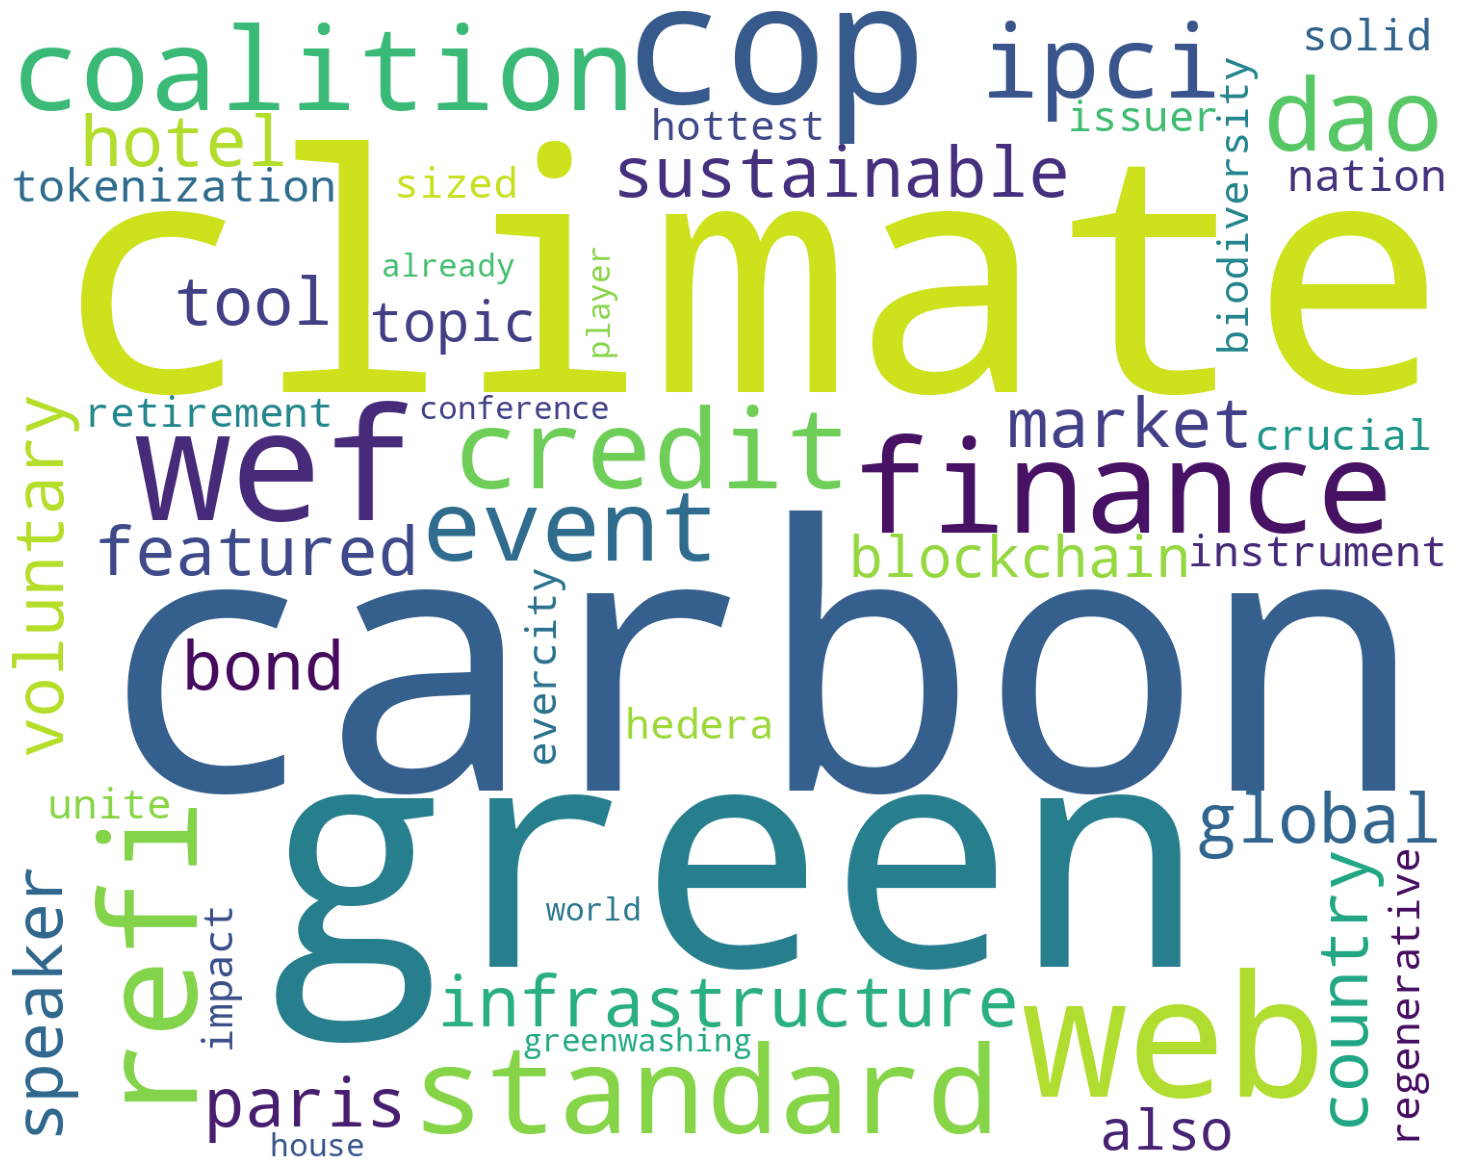

In [28]:
# generate word cloud
wordcloud = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=50).generate_from_frequencies( tfidf_df.to_dict('dict')['tfidf'] )

plt.figure( figsize=(20,15) )
plt.imshow( wordcloud )
plt.axis('off')
plt.savefig('tfidf_wordcloud.png')